<a href="https://colab.research.google.com/github/luisr96/Steelcase-Senior-IE-Project/blob/main/Steelcase%20Floorloading%20vs%20Stacking%20Comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Main

## Installing, importing and defining

In [1]:
# Google sheets
# Sheet used: https://docs.google.com/spreadsheets/d/1TC1f7JTJx8Kofbg3dff_JzNCKiGmIsqYIN7COGdaauI/edit#gid=2097386046

from google.colab import auth
auth.authenticate_user()
import gspread
from oauth2client.client import GoogleCredentials
gc = gspread.authorize(GoogleCredentials.get_application_default())

# Modules

import csv
import pandas as pd
import random
import math
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import copy
%matplotlib inline
import numpy as np


# Rectpack - heuristic algorithms used
# Documentation: https://github.com/secnot/rectpack

!pip install rectpack
from rectpack import newPacker

# High cube sea container definitions (inches)
hc_w = int(92)
hc_l = int(474.5)
hc_h = int(106)

roof_tolerance = int(8)

max_weight_to_stack = 100

# Amount of sea containers to fit packages into (big safe number)
amount = 20

class Pallet:
    def __init__(self, name="", length=0, width=0, height=0, weight=0):
        self.name = name
        self.length = length
        self.width = width
        self.height = height
        self.weight = weight

    def __repr__(self):
        return f"{self.name}"

pallet80 = Pallet(name="Pallet 927000080", length=111, width=40, height=4.75, weight=40)
pallet81 = Pallet(name="Pallet 927000081", length=100, width=40, height=4.75, weight=35)
pallet82 = Pallet(name="Pallet 927000082", length=89, width=40, height=4.75, weight=30)
pallet83 = Pallet(name="Pallet 927000083", length=78, width=40, height=4.75, weight=25)
pallet84 = Pallet(name="Pallet 927000084", length=67, width=40, height=4.75, weight=20)

## Pandas Dataframe

In [2]:
# read in the Google Sheets file into a pandas dataframe
wb = gc.open_by_url('https://docs.google.com/spreadsheets/d/1TC1f7JTJx8Kofbg3dff_JzNCKiGmIsqYIN7COGdaauI/edit#gid=1715628415')
sheet = wb.worksheet('order')
data = sheet.get_all_values()
df = pd.DataFrame(data)
df.columns = df.iloc[0]
df = df.iloc[1:]

# drop rows that don't have a value for width (i.e. don't have values for product or qty) in the google sheets
df = df[df['width'].astype(bool)] 

# specify data types for each column
df = df.astype({"product": str, "qty": int, "length": int, "width": int, "height": int, "weight": int, "palleted":str})

# arrange alphabetically
df = df.sort_values(by='product', ascending=True)

# show
df

,product,qty,length,width,height,weight,palleted
1,"(Case Study) MS LOUNGE,CORNER LEFT",5,94,35,29,23,
3,"(Case Study) MS LOUNGE,STRAIGHT",4,81,35,29,22,
2,"CTN,SPL M2X POWER UNIT,PACK - COLAGCL3 - P999865",13,16,9,5,1,


## Palletizing

In [3]:
# fit each package meant to be palletized into the smallest pallet possible

for i, row in df.iterrows():
    if (df['width'][i] <= pallet84.width) and \
    (df['length'][i] <= pallet84.length) and \
    (df['palleted'][i] != 'N'):
        df['width'][i] = pallet84.width
        df['length'][i] = pallet84.length
        df['height'][i] += pallet84.height
        df['weight'][i] += pallet84.weight

    elif (df['width'][i] <= pallet83.width) and \
    (df['length'][i] <= pallet83.length) and \
    (df['palleted'][i] != 'N'):
        df['width'][i] = pallet83.width
        df['length'][i] = pallet83.length
        df['height'][i] += pallet83.height
        df['weight'][i] += pallet83.weight

    elif (df['width'][i] <= pallet82.width) and \
    (df['length'][i] <= pallet82.length) and \
    (df['palleted'][i] != 'N'):
        df['width'][i] = pallet82.width
        df['length'][i] = pallet82.length
        df['height'][i] += pallet82.height
        df['weight'][i] += pallet82.weight

    elif (df['width'][i] <= pallet81.width) and \
    (df['length'][i] <= pallet81.length) and \
    (df['palleted'][i] != 'N'):
        df['width'][i] = pallet81.width
        df['length'][i] = pallet81.length
        df['height'][i] += pallet81.height
        df['weight'][i] += pallet81.weight

    elif (df['width'][i] <= pallet80.width) and \
    (df['length'][i] <= pallet80.length) and \
    (df['palleted'][i] != 'N'):
        df['width'][i] = pallet80.width
        df['length'][i] = pallet80.length
        df['height'][i] += pallet80.height
        df['weight'][i] += pallet80.weight

df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to b

,product,qty,length,width,height,weight,palleted
1,"(Case Study) MS LOUNGE,CORNER LEFT",5,100,40,33,58,
3,"(Case Study) MS LOUNGE,STRAIGHT",4,89,40,33,52,
2,"CTN,SPL M2X POWER UNIT,PACK - COLAGCL3 - P999865",13,67,40,9,21,


In [4]:
floor_loading_tuples = []

# for every row in dataframe
for i, row in df.iterrows():

    # for every qty per row
    for x in range(0,df['qty'][i]):

        #add length and width tuples to the list
        floor_loading_tuples.append((df['length'][i], df['width'][i]))

print(floor_loading_tuples)

[(100, 40), (100, 40), (100, 40), (100, 40), (100, 40), (89, 40), (89, 40), (89, 40), (89, 40), (67, 40), (67, 40), (67, 40), (67, 40), (67, 40), (67, 40), (67, 40), (67, 40), (67, 40), (67, 40), (67, 40), (67, 40), (67, 40)]


# Floor-loading only

In [5]:
# create "amount" amount of containers
# "amount" is an arbitrarily big safe number to ensure there's enough
containers = [(hc_l, hc_w)] * amount

packer_intocontainers = newPacker()

# Add pallets and non-palleted items into sea container
for r in floor_loading_tuples:
	packer_intocontainers.add_rect(*r)

for b in containers:
	packer_intocontainers.add_bin(*b)
 

packer_intocontainers.pack()

## Graphing the results (Floor-loading only)

In [6]:
ncontainers = len(packer_intocontainers)
print(f"{ncontainers} containers are used.")

2 containers are used.




Shipping Container #1: 474L x 92W
Pallets fit: 10


Shipping Container #2: 474L x 92W
Pallets fit: 12




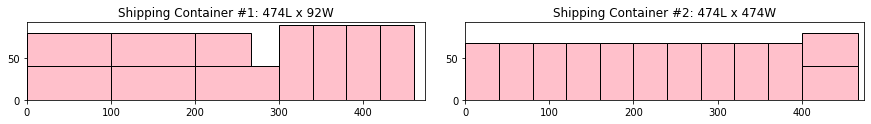

In [7]:
loc_dict = {}

fig = plt.figure(figsize=(15,15))

ncolumns = 2

# shape of subplot
shape = (int(math.ceil(ncontainers/ncolumns)), ncolumns)

print("\n")

counter = -1

i=0
while i < ncontainers:

    if (i % ncolumns == 0):
        counter += 1

    print(f"Shipping Container #{i+1}: {containers[i][0]}L x {containers[i][1]}W")
    plt.title(f"Shipping Container #{i}: {containers[i][0]}L x {containers[i][1]}W")

    loc_dict[i] = (counter, i % ncolumns)

    ax = plt.subplot2grid(shape=shape, loc=loc_dict[i])
                                     
    plt.ylim(0, containers[i][1])
    plt.xlim(0, containers[i][0])
    plt.gca().set_aspect('equal', adjustable='box')

    print(f"Pallets fit: {len(packer_intocontainers[i])}")

    # for every item in the container, draw it
    x=0
    while x < len(packer_intocontainers[i]):

        drawrect = patches.Rectangle((packer_intocontainers[i][x].x, packer_intocontainers[i][x].y), packer_intocontainers[i][x].width, 
                                 packer_intocontainers[i][x].height, linewidth=1, color='pink', ec="#000000")
        
        ax.add_patch(drawrect)

        x += 1

    print("\n")

    i += 1

plt.title(f"Shipping Container #{i}: {containers[i][0]}L x {containers[i][0]}W")

plt.subplots_adjust(left=None, bottom=0.60, right=None, top=None, wspace=0.1, hspace=0.1)

plt.savefig('floor_loading_only.png')

# Stacking

In [8]:
df_stacked = df.copy()
df_stacked

,product,qty,length,width,height,weight,palleted
1,"(Case Study) MS LOUNGE,CORNER LEFT",5,100,40,33,58,
3,"(Case Study) MS LOUNGE,STRAIGHT",4,89,40,33,52,
2,"CTN,SPL M2X POWER UNIT,PACK - COLAGCL3 - P999865",13,67,40,9,21,


In [9]:
odd_to_add = []
color_list = []

for i, row in df_stacked.iterrows():

    # if there is only 1 of an item, it can't be stacked and is red
    if df_stacked['qty'][i] == 1:
        print(f"There's only 1 of {df_stacked['product'][i]}")
        color_list += ['red']
        continue

    # hc_h is height of shipping container 
    # roof_tolerance between roof and top of heighest package was recommended 8"
    # however, can be changed if that changes

    # max_weight_to_stack is the most weight a bottom item can withstand and
    # will need to be changed based on mechanical engineers' design

    # if it's unstackable due to weight or height restrictions
    if ((2 * df_stacked['height'][i] >= (hc_h - roof_tolerance)) or (df_stacked['weight'][i] >= max_weight_to_stack)):
        print(f"{df_stacked['product'][i]} is unstackable.")
        color_list += ['red'] * df_stacked['qty'][i]
        continue

    # if qty is even and stackable in terms of height and weight
    if (df_stacked['qty'][i] % 2 == 0):
        print(f"There is an even number of {df_stacked['product'][i]}") 
        df_stacked['qty'][i] = df_stacked['qty'][i]/2
        df_stacked['product'][i] = 'stack of ' + df_stacked['product'][i]
        df_stacked['height'][i] = df_stacked['height'][i] * 2
        df_stacked['weight'][i] = df_stacked['weight'][i] * 2
        color_list += ['green'] * df_stacked['qty'][i]

    # if qty is odd and stackable in terms of height and weight,
    # put the leftover one in odd_to_add list
    elif (df_stacked['qty'][i] % 2 != 0):
        print(f"There is an odd number of {df_stacked['product'][i]}")
        df_stacked['qty'][i] = (df_stacked['qty'][i]-1)/2
        df_stacked['product'][i] = 'stack of ' + df_stacked['product'][i]
        df_stacked['height'][i] = df_stacked['height'][i] * 2
        df_stacked['weight'][i] = df_stacked['weight'][i] * 2
        
        odd_to_add.append([df_stacked['product'][i], 
                           1, 
                           df_stacked['length'][i],
                           df_stacked['width'][i],
                           df_stacked['height'][i] / 2,
                           df_stacked['weight'][i] / 2,
                           df_stacked['palleted'][i]])
        
        color_list += ['green'] * df_stacked['qty'][i]
        
        

    # if not stackable, floorload like normal
    else:
        print(f"{df_stacked['product'][i]} is unstackable")

print(odd_to_add)

df_stacked

There is an odd number of (Case Study) MS LOUNGE,CORNER LEFT
There is an even number of (Case Study) MS LOUNGE,STRAIGHT
There is an odd number of CTN,SPL M2X POWER UNIT,PACK - COLAGCL3 - P999865
[['stack of (Case Study) MS LOUNGE,CORNER LEFT', 1, 100, 40, 33.0, 58.0, ''], ['stack of CTN,SPL M2X POWER UNIT,PACK - COLAGCL3 - P999865', 1, 67, 40, 9.0, 21.0, '']]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to b

,product,qty,length,width,height,weight,palleted
1,"stack of (Case Study) MS LOUNGE,CORNER LEFT",2,100,40,66,116,
3,"stack of (Case Study) MS LOUNGE,STRAIGHT",2,89,40,66,104,
2,"stack of CTN,SPL M2X POWER UNIT,PACK - COLAGCL...",6,67,40,18,42,


In [10]:
# create df for the leftover items
column_names = ["product", "qty", "length", "width", "height", "weight", "palleted"]
df_leftover = pd.DataFrame(odd_to_add, columns = column_names)

for i, row in df_leftover.iterrows():
    color_list += ['red']

for i, row in df_leftover.iterrows():
    df_leftover['product'] = df_leftover['product'].map(lambda x: x.lstrip('stack of'))

df_leftover

,product,qty,length,width,height,weight,palleted
0,"(Case Study) MS LOUNGE,CORNER LEFT",1,100,40,33.0,58.0,
1,"CTN,SPL M2X POWER UNIT,PACK - COLAGCL3 - P999865",1,67,40,9.0,21.0,


In [11]:
print(color_list)
color_list = iter(color_list)

# combine the stacked df and leftover df
df_stacked_and_leftover = pd.concat([df_stacked, df_leftover], ignore_index=True, sort=False)
df_stacked_and_leftover

['green', 'green', 'green', 'green', 'green', 'green', 'green', 'green', 'green', 'green', 'red', 'red']


,product,qty,length,width,height,weight,palleted
0,"stack of (Case Study) MS LOUNGE,CORNER LEFT",2,100,40,66.0,116.0,
1,"stack of (Case Study) MS LOUNGE,STRAIGHT",2,89,40,66.0,104.0,
2,"stack of CTN,SPL M2X POWER UNIT,PACK - COLAGCL...",6,67,40,18.0,42.0,
3,"(Case Study) MS LOUNGE,CORNER LEFT",1,100,40,33.0,58.0,
4,"CTN,SPL M2X POWER UNIT,PACK - COLAGCL3 - P999865",1,67,40,9.0,21.0,


## Stacking results

In [12]:
stacked_tuples = []

for i, row in df_stacked_and_leftover.iterrows():
    for x in range(0,df_stacked_and_leftover['qty'][i]):
        stacked_tuples.append((df_stacked_and_leftover['length'][i],
                               df_stacked_and_leftover['width'][i]))

print(stacked_tuples)

[(100, 40), (100, 40), (89, 40), (89, 40), (67, 40), (67, 40), (67, 40), (67, 40), (67, 40), (67, 40), (100, 40), (67, 40)]


In [13]:
containers_stacked = [(hc_l, hc_w)] * amount

packer_intocontainers_stacked = newPacker()


# Add pallets and non-palleted items into sea container
for r in stacked_tuples:
	packer_intocontainers_stacked.add_rect(*r)

for b in containers_stacked:
	packer_intocontainers_stacked.add_bin(*b)
 

packer_intocontainers_stacked.pack()

In [14]:
ncontainers_stacked = len(packer_intocontainers_stacked)
print(f"{ncontainers_stacked} containers are used.")

2 containers are used.




Shipping Container #1: 474L x 92W
Pallets fit: 11


Shipping Container #2: 474L x 92W
Pallets fit: 1




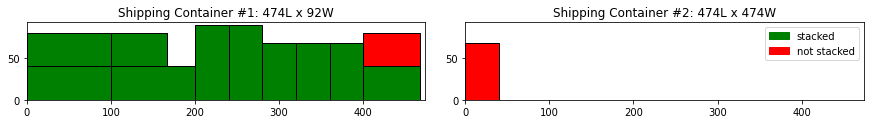

In [15]:
loc_dict = {}

fig = plt.figure(figsize=(15,15))

ncolumns = 2

shape = (int(math.ceil(ncontainers_stacked/ncolumns)), ncolumns)

usedpallets = []

print("\n")

counter = -1

i=0
while i < ncontainers_stacked:

    if (i % ncolumns == 0):
        counter += 1

    print(f"Shipping Container #{i+1}: {containers_stacked[i][0]}L x {containers_stacked[i][1]}W")
    plt.title(f"Shipping Container #{i}: {containers_stacked[i][0]}L x {containers_stacked[i][1]}W")

    loc_dict[i] = (counter, i % ncolumns)

    ax = plt.subplot2grid(shape=shape, loc=loc_dict[i])
                                     
    plt.ylim(0, containers_stacked[i][1])
    plt.xlim(0, containers_stacked[i][0])
    plt.gca().set_aspect('equal', adjustable='box')

    print(f"Pallets fit: {len(packer_intocontainers_stacked[i])}")

    x=0
    while x < len(packer_intocontainers_stacked[i]):

        drawrect = patches.Rectangle((packer_intocontainers_stacked[i][x].x, packer_intocontainers_stacked[i][x].y), packer_intocontainers_stacked[i][x].width, 
                                 packer_intocontainers_stacked[i][x].height, linewidth=1, color=next(color_list), ec="#000000")
        
        ax.add_patch(drawrect)

        x += 1

    print("\n")

    i += 1

plt.title(f"Shipping Container #{i}: {containers_stacked[i][0]}L x {containers_stacked[i][0]}W")

plt.subplots_adjust(left=None, bottom=0.60, right=None, top=None, wspace=0.1, hspace=0.1)

green_patch = patches.Patch(color='green', label='stacked')
red_patch = patches.Patch(color='red', label='not stacked')
plt.legend(handles=[green_patch, red_patch])

plt.savefig('stacking.png')

# Reporting

## Optimal floor loading

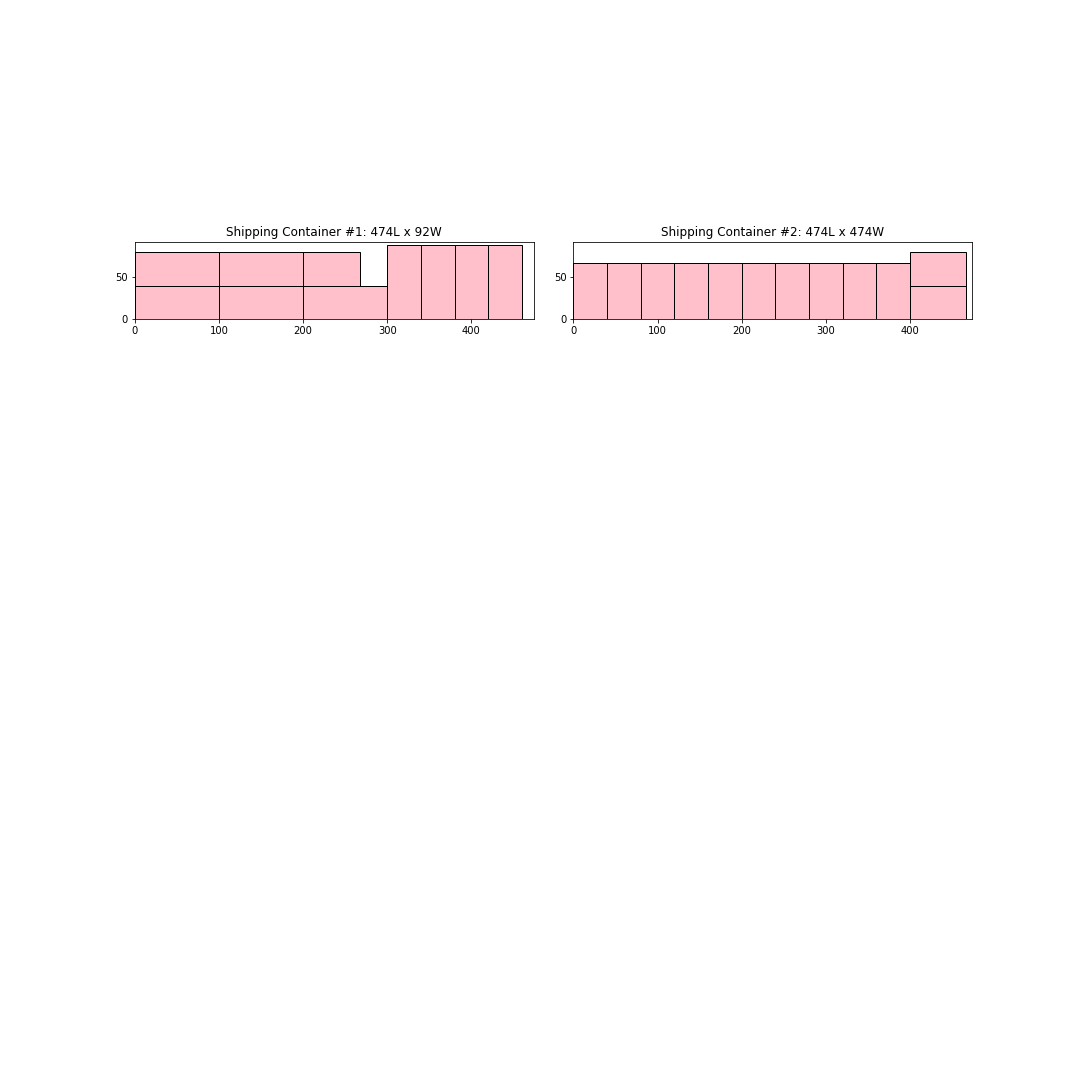

In [16]:
from IPython.display import Image
Image('floor_loading_only.png')

## Stack loading

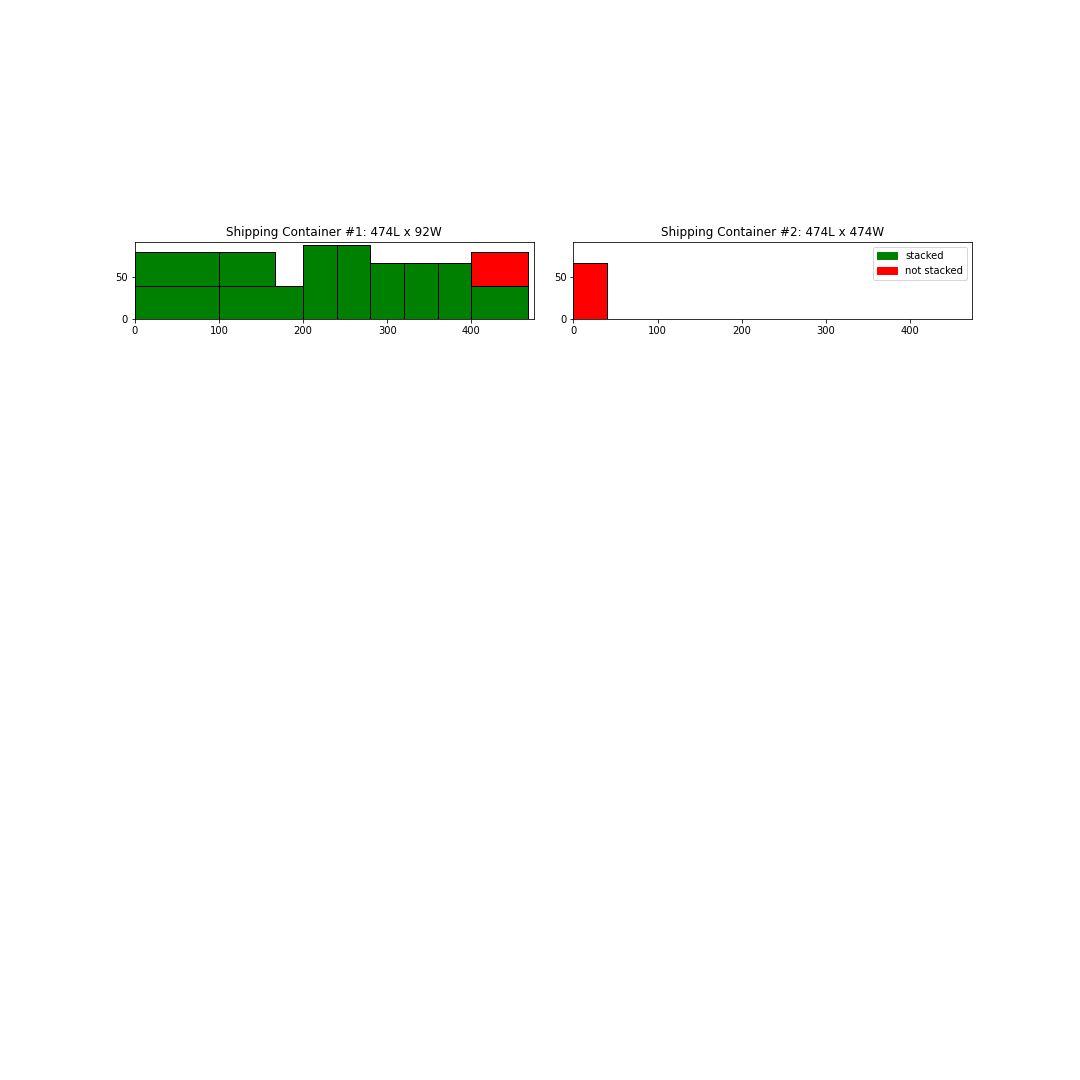

In [17]:
Image('stacking.png')

## CSV files for data analysis

In [18]:
reportheader = ['sales order', '# of containers optimal floorloading', '# of containers stacking']

# creates a csv file
with open('highcube_capacity_statistics.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(reportheader)
    writer.writerow([8195006, ncontainers, ncontainers_stacked])

# adds to the csv file. change datasheets 
with open('highcube_capacity_statistics.csv', 'a', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Shipment Number", ncontainers, ncontainers_stacked])